This is the first of the two steps in reinterpreting our result in [XENONnT first light DM search](https://arxiv.org/pdf/2409.17868). 

In this notebook, we show how you can generate templates of signals and backgrounds. More specifically, you will see how to:
- **Typically for theorists**: Based on our YBe-calibrated yield models, generate signal templates of your own new physics model to search for.
- **Typically for experimentalists**: Based on signal models published in our paper, generate signal and background templates based on the new yield models.
- Based on your own yield models, generate signal templates of your own new physics model to search for, together with the corresponding background models

In [1]:
import numpy as np
import os
import json
from tqdm import tqdm
from inference_interface import template_to_multihist
import scipy.stats as stats
from appletree.utils import load_json
from light_wimp_data_release import Template
from light_wimp_data_release import make_spectrum, load_default_yield_model, produce_templates

# Just some plotting settings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.colors import Normalize
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [4, 3]
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = 9
mpl.rcParams["mathtext.fontset"] = "dejavuserif"

XLA_PYTHON_CLIENT_PREALLOCATE is set to false
XLA_PYTHON_CLIENT_ALLOCATOR is set to platform
Cannot find aptext


/opt/anaconda3/envs/light_wimp_data_release/lib/python3.11/site-packages/appletree/__init__.py:51: UserWarning: You are running appletree on CPU, which usually results in low performance.
  warn(warning)


# Introduction

In this introductory section, we will just illustrate the concept of signal and background templates, and describe the fast template generation method applied in this package. For experienced users, you can just skip this section.

## Warmup: WIMP recoil energy spectrums

Below we show the normalized solar $^8\mathrm{B}$ $\mathrm{CE}\nu\mathrm{NS}$ and WIMP spectrums calculated by [the wimprates package](https://github.com/JelleAalbers/wimprates). Note that these are theoretical spectrums before any detector effects, and later you can also feed your own favourite models (spectrums) to reinterpret our results. 

In [2]:
def get_spec_pdf(loaded_spec_json):
    """Reformat the loaded json spectrum from CDF into PDF. 
    Note that all the specturms are stored in CDF.
    "map" means NR recoil energy in keV, and "coordinate_system" is the CDF value.
    """
    energies = (np.array(loaded_spec_json["map"])[1:] + np.array(loaded_spec_json["map"])[:-1])/2
    energy_bin_widths = np.array(loaded_spec_json["map"])[1:] - np.array(loaded_spec_json["map"])[:-1]
    spectrum = np.diff(loaded_spec_json['coordinate_system']) / energy_bin_widths
    return energies, spectrum

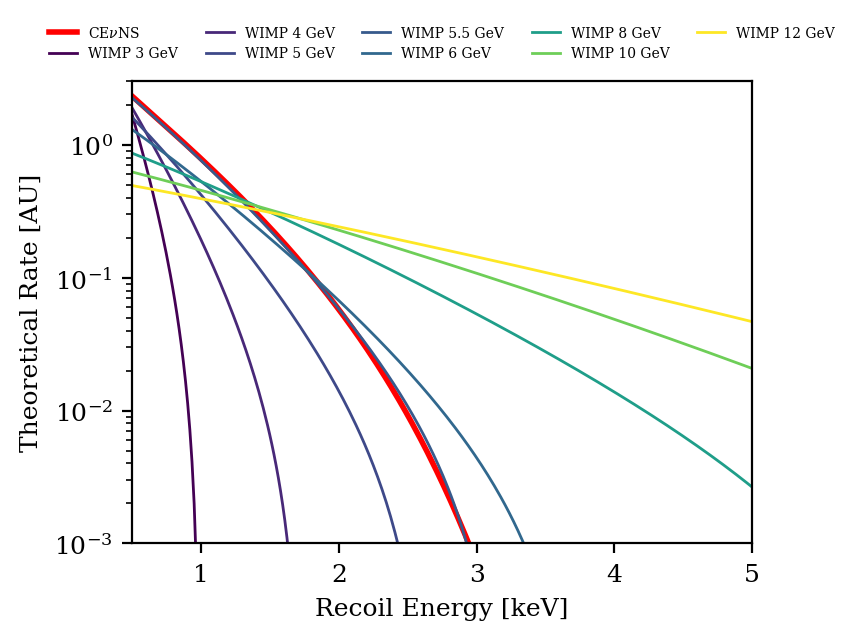

In [3]:
# Define your data path and wms
data_path = "../light_wimp_data_release/data/"
wms = [3, 4, 5, 5.5, 6, 8, 10, 12]

# Load the CEvNS spectrum data and plot it in red
cevns_spectrum_json = load_json(os.path.join(data_path, "signal/cevns_spectrum.json"))
_energies, _spectrum = get_spec_pdf(cevns_spectrum_json)
plt.plot(_energies, _spectrum*1.15, color="red", lw=2, label=r"$\mathrm{CE}\nu\mathrm{NS}$")

# Generate colors for each WIMP mass
norm = Normalize(vmin=min(wms), vmax=max(wms))
cmap = cm.viridis  # Choose a colormap
colors = [cmap(norm(wm)) for wm in wms]

# Plot WIMP spectra with mapped colors
for idx, _wm in enumerate(wms):
    _wimp_spectrum_json = load_json(os.path.join(data_path, f"signal/wimp_si_spectrum_{_wm}.json"))
    _energies, _spectrum = get_spec_pdf(_wimp_spectrum_json)
    plt.plot(_energies, _spectrum, lw=1, color=colors[idx], label=f"WIMP {_wm} GeV")

# Set plot limits, scale, labels, and legend
plt.xlim(0.5, 5)
plt.ylim(1e-3, 3e0)
plt.yscale("log")
plt.xlabel("Recoil Energy [keV]")
plt.ylabel("Theoretical Rate [AU]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, frameon=False, fontsize=5)

# Show the plot
plt.show()

## Warmup: Yield model and template

As we will introduce in the next notebook, the yield model "shape parameters" `tly` and `tqy` will be used in inference as two nuisance parameters. Below we show the YBe-calibrated yield model (light yield $L_t$ and charge yield $Q_y$) as we based on in the paper.

In [4]:
# Load the published YBe-calibrated yield models into a dict.
ybe_yield_models = load_default_yield_model()

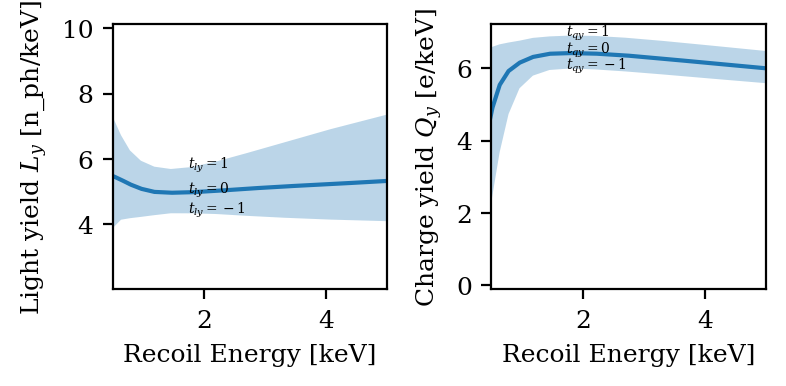

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

for i_ax, i, ylb in zip([0, 1], ['ly', 'qy'], ["Light yield $L_y$ [n_ph/keV]", "Charge yield $Q_y$ [e/keV]"]):
    # Nominal yield model
    ax[i_ax].plot(ybe_yield_models[i+"_median"]['coordinate_system'], ybe_yield_models[i+"_median"]['map'])
    # Uncertainty of the yield models, corresponding to shape parameter t=+/-1
    ax[i_ax].fill_between(ybe_yield_models[i+"_median"]['coordinate_system'], 
                          ybe_yield_models[i+"_lower"]['map'], 
                          ybe_yield_models[i+"_upper"]['map'], 
                          alpha=0.3)

    # Label the yield shape parameter
    label_index = 250
    for t, s in zip([-1, 0, 1], ["lower", "median", "upper"]):
        ax[i_ax].text(ybe_yield_models[i+"_"+s]['coordinate_system'][label_index], 
                      ybe_yield_models[i+"_"+s]['map'][label_index],
                      "$t_{%s}=%s$"%(i, t), 
                      fontsize=(5))

    ax[i_ax].set_xlabel("Recoil Energy [keV]")
    ax[i_ax].set_ylabel(ylb)
    ax[i_ax].set_xlim(0.5, 5)    
plt.tight_layout()
plt.show()

## Warmup: Templates used in search for SI DM in the paper

A template, means the expected rate distribution of a certain source (a signal or a background) in the 4-dimensional search space (cS2, S2pre/dT, S1BDT, S2 BDT). In other word, it means . In this sub-section, we help you visualize the original templates used in the search for light DM of spin-independent interaction reported in our paper. 

For illustration, we will just show the templates based on median light/charge yield, and this is reflected in the file name (`*tly_0.0_tqy_0.0*`, where the two "shape parameters" `tly` and `tqy` are set `0.0`). The two science runs (SR0 and SR1) are slightly different because of detector configuration, and their templates are computed respectively.

In [6]:
# Load official template used in the analysis
wm = 6 # In unit of GeV
srs = ['sr0', 'sr1']
# Sources without NR yield model dependence in templates
sources_else = [
    "sr0_ac", "sr1_ac",
    "sr0_er", "sr1_er",
]
# Sources with NR yield model dependence in templates
sources_nr = [
    f"sr0_wimp_si_{wm}", f"sr1_wimp_si_{wm}",
    "sr0_b8", "sr1_b8",
    "sr0_rg", "sr1_rg"
]
sources = sources_nr + sources_else

In [7]:
# Load the templates for all sources
official_templates = dict()

for source in sources_nr:
    folder_name = source.split("sr")[-1][2:].split(f"_{wm}")[0]
    official_templates[source] = template_to_multihist(
        os.path.join(
            data_path, 
            f"{folder_name}/template_XENONnT_{source}_cevns_tly_0.0_tqy_0.0.h5")
    )['template']
    
for source in sources_else:
    folder_name = source.split("sr")[-1][2:].split(f"_{wm}")[0]
    official_templates[source] = template_to_multihist(
        os.path.join(
            data_path, 
            f"{folder_name}/template_XENONnT_{source}_cevns.h5")
    )['template']

Here we show the 1D projections of the templates. Note that, the bins have been defined so that the accidental coincidence templates are almost flat in each 1D projection. For all the backgrounds, the rates are set to the expectation in [TABLE 1 of the paper](https://arxiv.org/pdf/2409.17868). For WIMP of SI interactions, the rate corresponds to a cross section $\sigma_{SI}=10^{-45}\mathrm{cm}^2$.

Jargons:
- `er`: Electronic recoil backgrounds.
- `ac`: Accidental coincidence backgrounds.
- `rg`: Radiogenic neutron backgrounds.
- `b8`: Solar $^8\mathrm{B}$ $\mathrm{CE}\nu\mathrm{NS}$ backgrounds.
- `wimp_si_<m>`: $m$ GeV WIMP (SI interaction) signal.

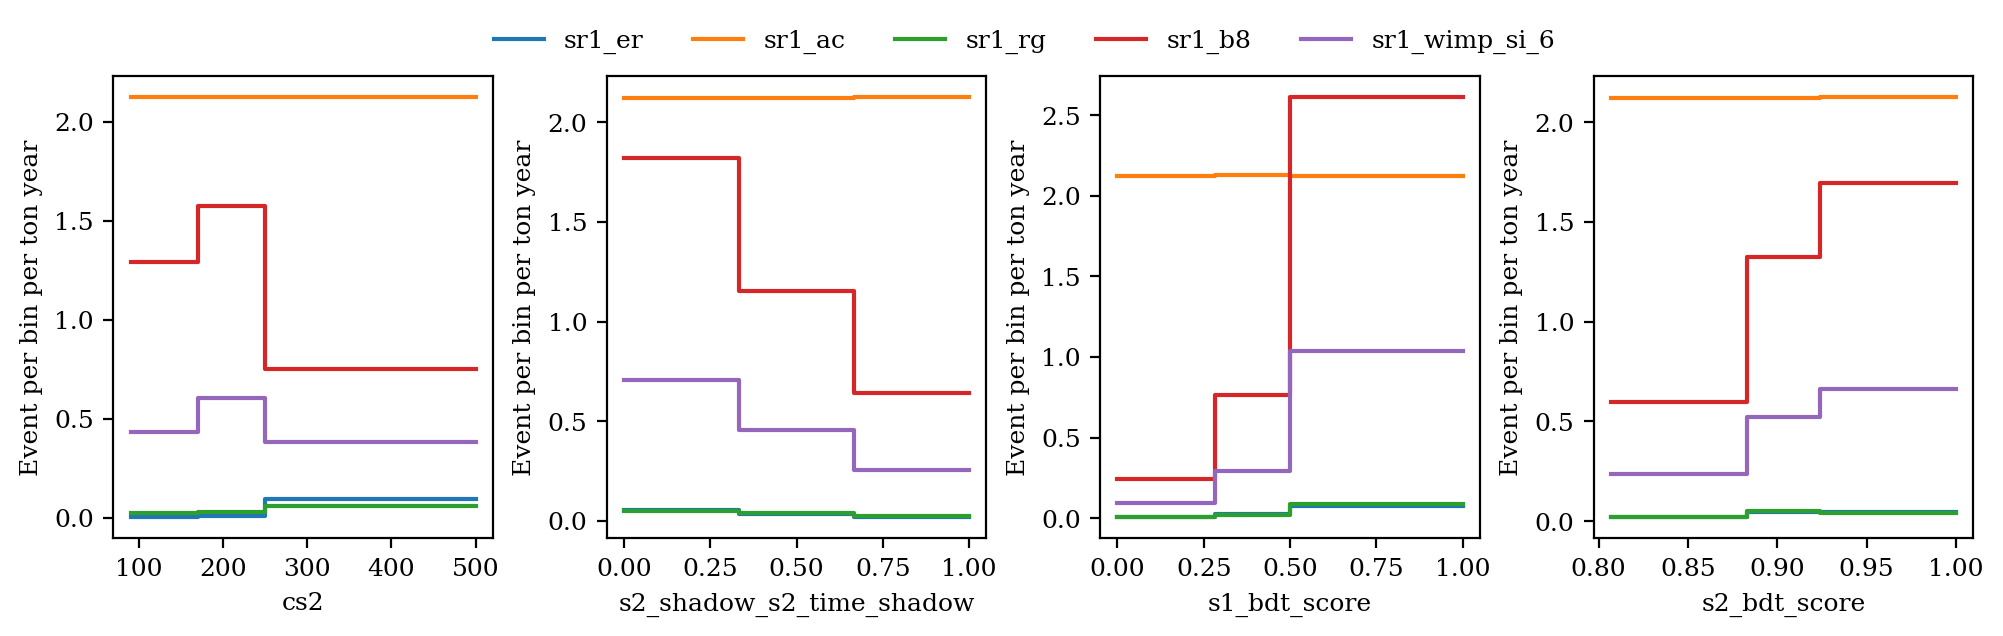

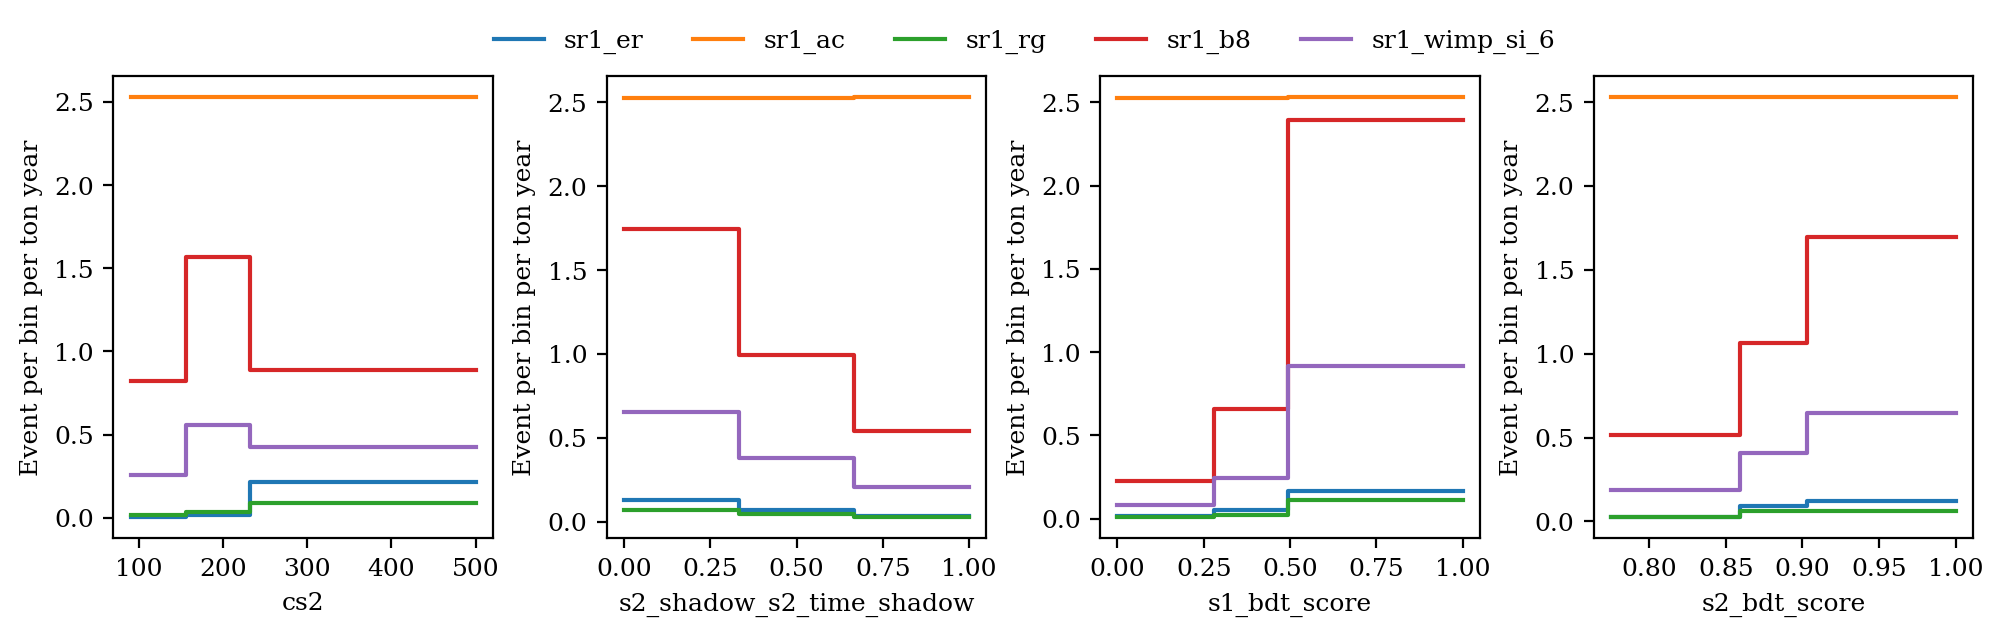

In [8]:
for sr in ['sr0', 'sr1']:
    fig = plt.figure(figsize=(12, 3))
    grid = plt.GridSpec(1, 4, wspace=0.3)
    
    for i, axis in enumerate(['cs2', 's2_shadow_s2_time_shadow', 's1_bdt_score', 's2_bdt_score']):
        for _source in sources[::-2]:
            source = _source[4:] # Removed sr0/sr1 heading.
            plt.subplot(grid[i])
            official_templates[sr+"_"+source].project(axis=axis).plot(label=_source)
        
        plt.xlabel(axis)
        plt.ylabel('Event per bin per ton year')

    plt.legend(loc='upper center', bbox_to_anchor=(-1.5, 1.15), ncol=5, frameon=False)
    plt.show()

You can also play around the codes above, to load signal templates of other models we reported searches for. Just replace `wimp_si` with one of the following:
- `wimp_si_n_1`: Momentum Dependent DM with `n=1`.
- `wimp_si_n_2`: Momentum Dependent DM with `n=2`.
- `wimp_si_n_m2`: Momentum Dependent DM with `n=-2`, which can be interpreted as self-interacting DM with a light mediator.
- `mirror_dm`: Mirror oxygen DM. 

You can see from above that electronic recoil and radiogenic neutrons contribute subdominantly. Later when recasting the results, we will just neglect the yield model dependence in radiogenic neutron backgrounds for simplicity, without loss of accuracy.

Below, we visualize how a signal template changes due to the uncertainty of yield model. 

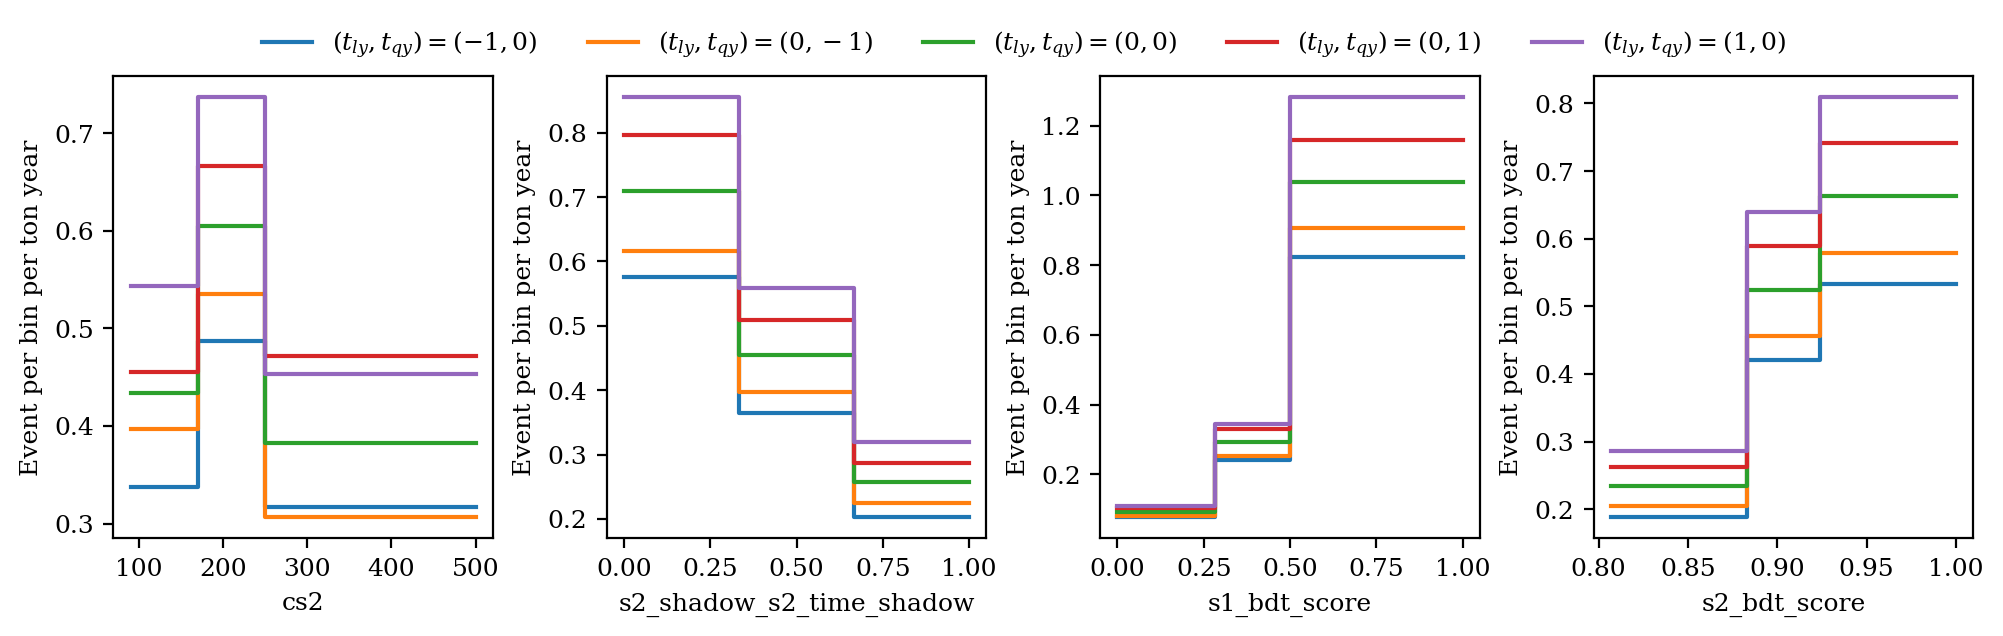

In [9]:
# Visualize the signal templates with different (tly, tqy)
signal_templates = dict()
sr = "sr0"
source = f"wimp_si_{wm}" # WIMP of SI interaction
folder_name = source.split(f"_{wm}")[0]

fig = plt.figure(figsize=(12, 3))
grid = plt.GridSpec(1, 4, wspace=0.3)

for tly, tqy in zip([-1, 0, 0, 0, 1], [0, -1, 0, 1, 0]):
    # Load template
    _template = template_to_multihist(
        os.path.join(
            data_path, 
            f"{folder_name}/template_XENONnT_{sr}_{source}_cevns_tly_{tly}.0_tqy_{tqy}.0.h5")
    )['template']
    
    for i, axis in enumerate(['cs2', 's2_shadow_s2_time_shadow', 's1_bdt_score', 's2_bdt_score']):
        plt.subplot(grid[i])
        _template.project(axis=axis).plot(label=r"$(t_{ly}, t_{qy})=(%s,%s)$"%(tly, tqy))
        
        plt.xlabel(axis)
        plt.ylabel('Event per bin per ton year')

plt.legend(loc='upper center', bbox_to_anchor=(-1.5, 1.15), ncol=5, frameon=False)

## Fast template generation method

As you can see from above, a template depends on both yield models and recoil energy spectrum. The templates shown above were computed by a detector response simulation using [appletree package](https://github.com/XENONnT/appletree), which is computationally expensive. For users to reinterpret our results, we provide here a fast template generation method.

Here is the general idea of how this fast template generation method works: We simulate mono-energetic peaks in the range of [0.5, 5] keV (in practice [0.51, 0.6 , 0.7 , 0.8 , 0.9 , 1.  , 1.25, 1.5 , 1.75, 2.  , 2.5 , 3.  , 3.5 , 4.  , 4.5 , 5.  ]), with light yield of [1, 10] ph/keV and charge yield of [1, 10] e-/keV (with step 1.0). As a result, we create a basis, or voxels in $(E_R, L_y, Q_y)$, to interpolate any signal spectrum $S(E_R)$ with any yield model. The custom 4D template $T(S(E_R), L_Y, Q_Y)$ for a specific signal model with nuclear recoil spectrum of $E_R$ and yield model $(L_Y, Q_Y)$ is:

$T(S(E_R), L_Y(E_R), Q_Y(E_R)) = \int_{E_{min}}^{E_{max}} S(E_R) T^{\prime}(E_R, L_Y(E_R), Q_Y(E_R)) \,dE_R $,

where minimum and maximum energy truncate at 0.51 keV and 5.0 keV respectively, and $T^{\prime}$ is the 4D template determined by voxel $(E_R, L_y, Q_y)$. Practically, the integral is approximated by sum. 



Each template of a single voxel in $(E_R, L_y, Q_y)$ was still computed by the detector response simulation, and we have computed for you already. Here is an example of the template of a single voxel:

In [10]:
sr = "sr0"
vox_er = 5 # E_R = 5 keV_NR
vox_ly = 4 # L_y = 5 ph/keV_NR
vox_qy = 6 # L_y = 5 e-/keV_NR
vox_template_name = f"template_XENONnT_{sr}_recasting_mono_{vox_er}_0_cevns_tly_{vox_ly}_tqy_{vox_qy}.h5"

vox_template = template_to_multihist(
    os.path.join(
        data_path, 
        f"orthonormal_basis/{vox_template_name}")
)['template']

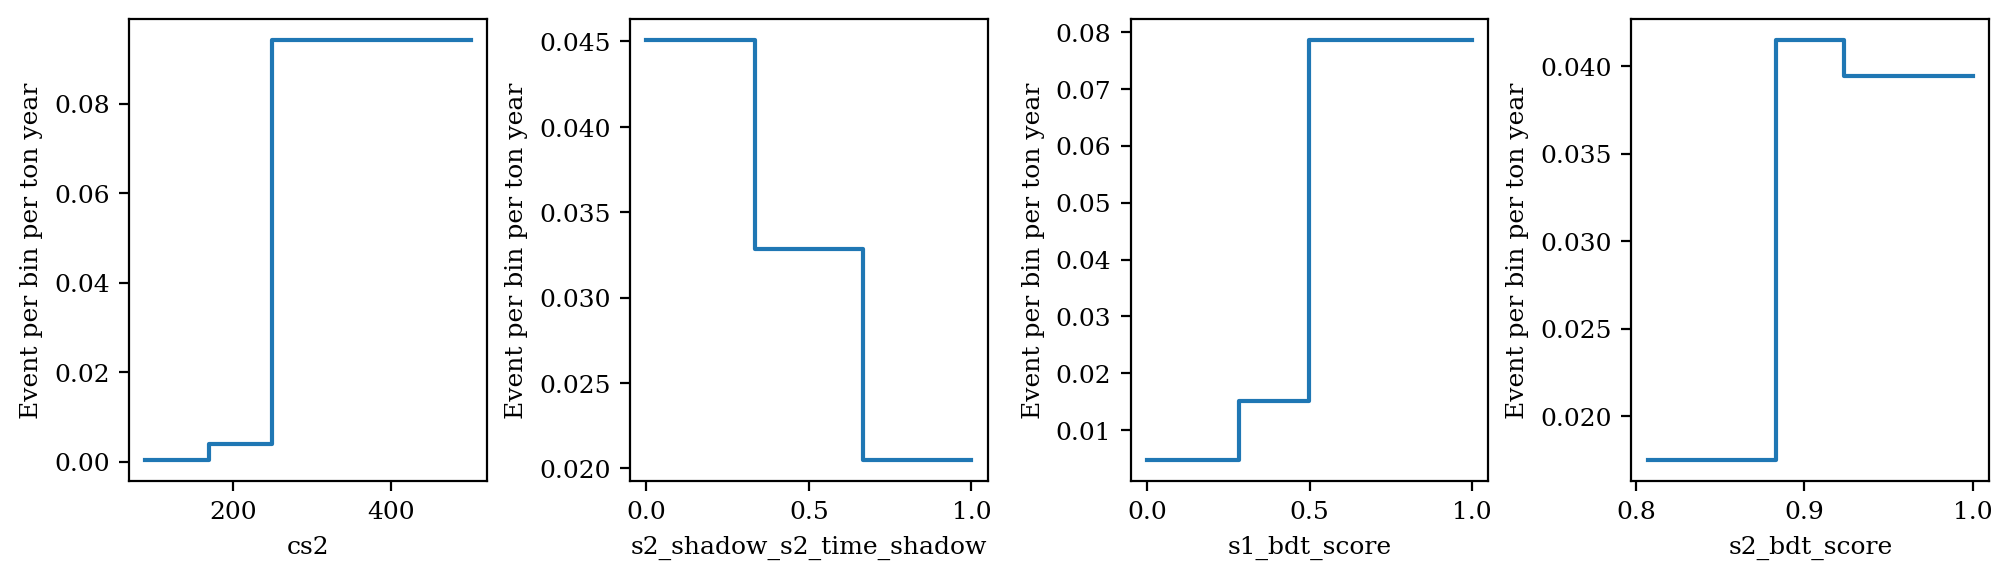

In [11]:
# Visualize a voxel template
fig = plt.figure(figsize=(12, 3))
grid = plt.GridSpec(1, 4, wspace=0.4)
for i, axis in enumerate(['cs2', 's2_shadow_s2_time_shadow', 's1_bdt_score', 's2_bdt_score']):
    plt.subplot(grid[i])
    vox_template.project(axis=axis).plot()
    
    plt.xlabel(axis)
    plt.ylabel('Event per bin per ton year')

Here is an example on how to use this method to generate the template of a WIMP of SI interaction, assuming the nominal (median) YBe-calibrated yield model.

In [12]:
# Initalize fast simulation object.
template = Template()

# Load yield model curve.
data_path = '../light_wimp_data_release/data/'
# Every time before fast template generation, you will want to make a yield model dictionary like this.
yield_model = {
    'ly': load_json(os.path.join(data_path, "signal/ly_ybe_model_median.json")),
    'qy': load_json(os.path.join(data_path, "signal/qy_ybe_model_median.json"))
}

# Load analytically computed spectrum.
wm = 6 # 6 GeV
wimp_spectrum = load_json(os.path.join(data_path, f"signal/wimp_si_spectrum_{wm}.json"))

# Perform fast template generation.
fast_templates = template.build_template(wimp_spectrum, yield_model)

# Load the official template computed by full detector simulation.
official_templates = {}
for sr in ['sr0', 'sr1']:
    official_templates[sr] = template_to_multihist(os.path.join(
        data_path, 
        f'wimp_si/template_XENONnT_{sr}_wimp_si_{wm}_cevns_tly_0.0_tqy_0.0.h5')
    )['template']

The validity can be validated by comparing the fast-simulation template with this method with the official WIMP spectrum used in the inference, where massive statistics were used. As shown below, we have a decent matching of the analysis dimensions for the data release template.

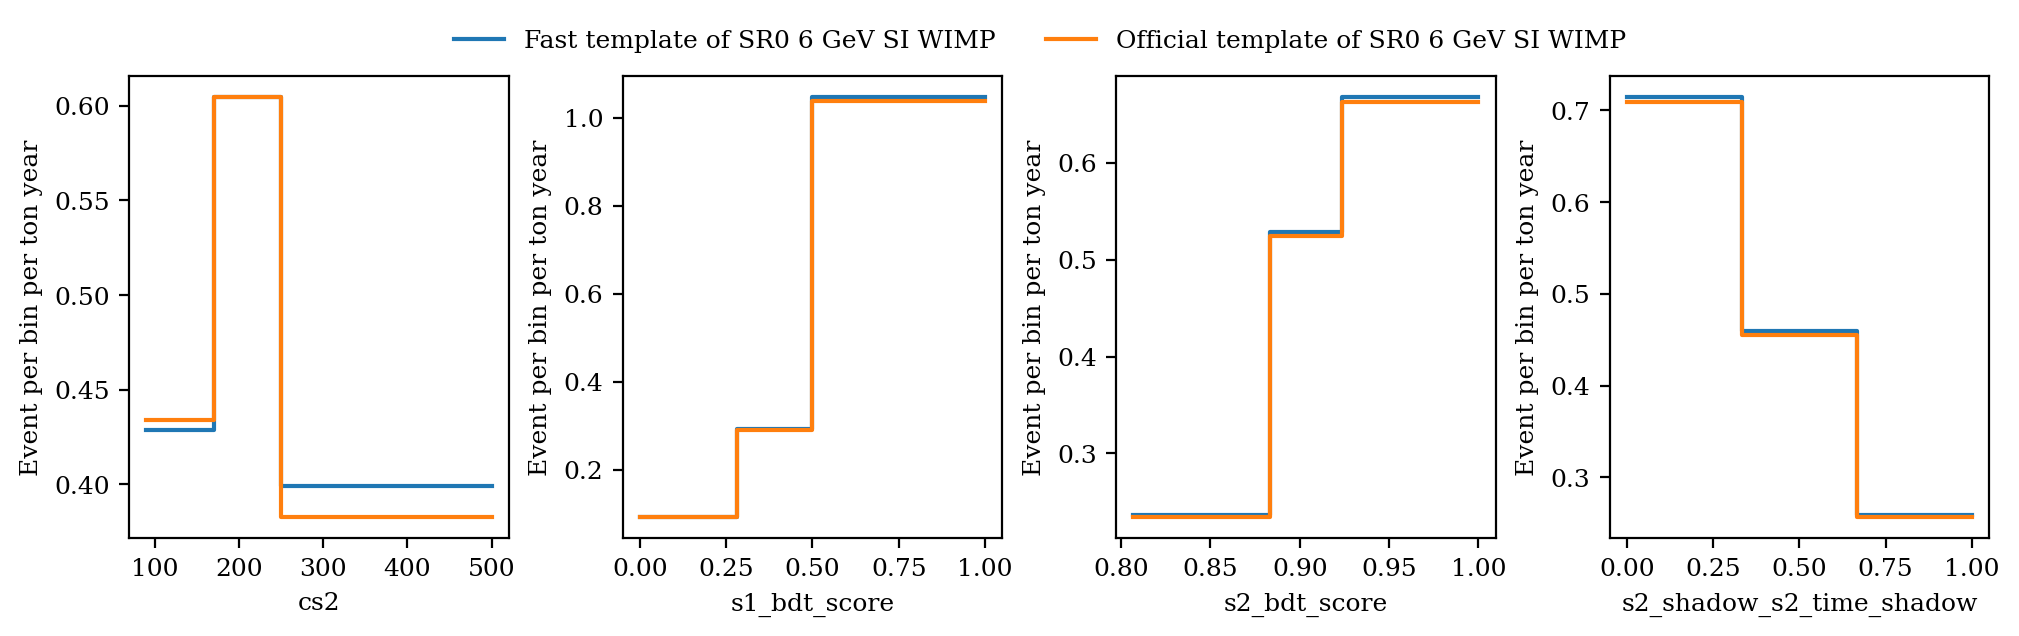

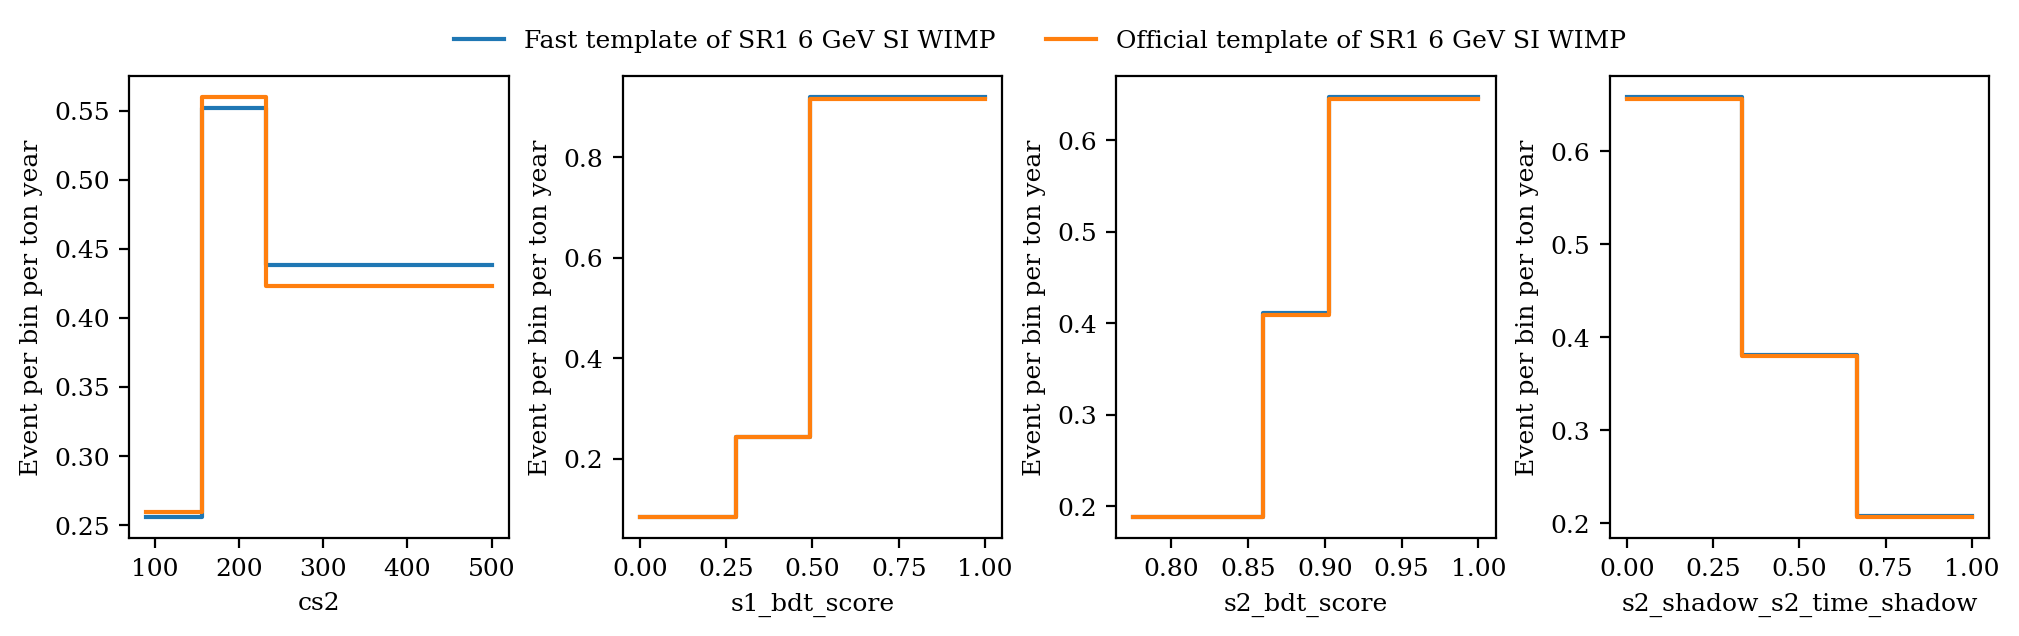

In [13]:
# Compared data released templates
for sr in ['sr0', 'sr1']:
    fig = plt.figure(figsize=(12, 3))
    grid = plt.GridSpec(1, 4, wspace=0.3)
    
    for i, axis in enumerate(['cs2', 's1_bdt_score', 's2_bdt_score', "s2_shadow_s2_time_shadow"]):
        plt.subplot(grid[i])
        
        fast_templates[sr].project(axis=axis).plot(label=f'Fast template of {sr.upper()} {wm} GeV SI WIMP',)
        official_templates[sr].project(axis=axis).plot(label=f'Official template of {sr.upper()} {wm} GeV SI WIMP')
        plt.xlabel(axis)
        plt.ylabel('Event per bin per ton year')

    plt.legend(loc=1)
    #fig.suptitle(f'6 GeV SI WIMP {sr}')
    plt.legend(loc='upper center', bbox_to_anchor=(-1.5, 1.15), ncol=5, frameon=False)
    plt.show()

As you can see, the discrepancy is quite small. In the next notebook, we will see that it leads to negligible discrepancy in the inferred limits. We have already performed this check on all models we considered in paper, and the match is decent.

# Generate templates with a different signal model (typically for theorist)

In this section, we show you how to generate templates with a different signal model. Note that you won't have to worry about background templates, as you can just reuse the official ones. Here we make an example of a fermionic absorption DM model which gives you a monoenergetic NR signal, similar to [this paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.129.161803). We assume the theoretical recoil spectrum to be a Gaussian shape with parameters $(E_{\mu}, E_{\sigma})$

It is very important to note that, for whatever new physics model you intend to reinterpret our results for, you need to figure out the **theoretical signal rate before any detector effects, in the unit of events per ton year**. In the next notebook, we will give limits on the multiplier of this rate.

It is also important to note that, our search ROI is **0.5-5.0keV**, please truncate your spectrum accordingly. If your spectrum is significantly out of that range, then it means this paper is not the best one to constrain your model.

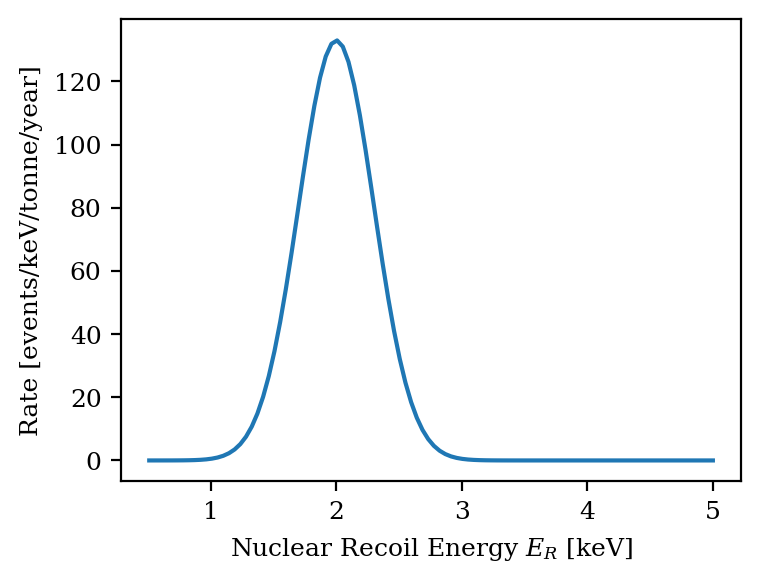

In [14]:
# Property of the spectrum
e_mu, e_sigma = 2, 0.3 # keV
nominal_rate = 100 # events per ton year

# Define the x and y of the spectrum
fermionic_er = np.linspace(0.51, 5, 100)
fermionic_dr_der = stats.norm.pdf(fermionic_er, e_mu, e_sigma) * nominal_rate

plt.plot(fermionic_er, fermionic_dr_der)
plt.xlabel('Nuclear Recoil Energy $E_R$ [keV]')
plt.ylabel('Rate [events/keV/tonne/year]')
plt.show()

In [15]:
# Make the spectrum object readable by template building functions.
fermionic_spectrum = make_spectrum(fermionic_er, fermionic_dr_der)

Now we produce templates based on the default YBe yield model. It might take minutes, as we need to enumerate all `(tly, tqy)` to account for the previously introduced yield parameter dependence in templates.

In [16]:
# It might take minutes
produce_templates(source_name="fermionic", 
                  output_folder="../light_wimp_data_release/data/fermionic_ybe", 
                  spectrum=fermionic_spectrum, 
                  yield_model=load_default_yield_model())

Producing Templates for fermionic:   0%|          | 0/98 [00:00<?, ?it/s]

Now you are all set! You can go to the next notebook. You can just build templates for your own new physics signal model repeating and adjusting the practice above.

# Generate templates with a different yield model (Typically for experimentalists)

In this section, we show you how to generate signal templates (for DM models considered in the paper) and $^8\mathrm{B}$ background templates, with a customized yield model. 

Among all the considered backgrounds, $^8\mathrm{B}$ is the only one whose templates should be generated every time you apply a new yield model. For the rest:
- AC background is completely modeled data-drivenly, thus yield-model-independent.
- ER background is independent of NR yield model.
- RG (Radiogenic neutron) background is subdominant. **We will not rebuild templates for RG**, and always assume the RG background model based on YBe yield model, for the convenience of users. In principle, we can just rebuild the RG background template with your customized yield model following the same fast template generation protocol. However, we just neglect the discrepancy of RG background template under different yield models, as it can hardly affect the limit on new physics in any significant level.

For simplicity, let's assume that you want to replace the YBe model we introduced earlier, by a linear model, as depicted below.

In [17]:
# Definition of linear yield model
linear_ly_median = {
    "coordinate_system": np.linspace(0.5, 5, 100).tolist(),
    "map": np.linspace(2, 5, 100).tolist()
}
linear_qy_median = {
    "coordinate_system": np.linspace(0.5, 5, 100).tolist(),
    "map": np.linspace(6, 4, 100).tolist()
}
linear_ly_lower = {
    "coordinate_system": linear_ly_median["coordinate_system"],
    "map": list(np.array(linear_ly_median["map"]) - 0.3)
}
linear_qy_lower = {
    "coordinate_system": linear_qy_median["coordinate_system"],
    "map": list(np.array(linear_qy_median["map"]) - 0.2)
}
linear_ly_upper = {
    "coordinate_system": linear_ly_median["coordinate_system"],
    "map": list(np.array(linear_ly_median["map"]) + 0.3)
}
linear_qy_upper = {
    "coordinate_system": linear_qy_median["coordinate_system"],
    "map": list(np.array(linear_qy_median["map"]) + 0.2)
}

linear_yield_models = {
    "ly_lower": linear_ly_lower,
    "ly_median": linear_ly_median,
    "ly_upper": linear_ly_upper,
    "qy_lower": linear_qy_lower,
    "qy_median": linear_qy_median,
    "qy_upper": linear_qy_upper
}

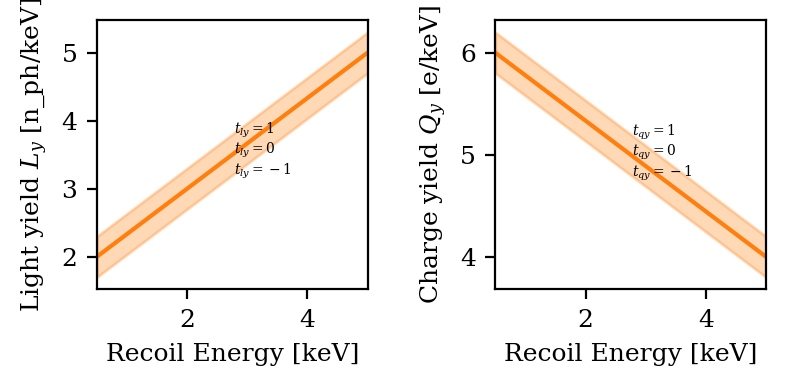

In [18]:
# Visualize the linear yield model
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

for i_ax, i, ylb in zip([0, 1], ['ly', 'qy'], ["Light yield $L_y$ [n_ph/keV]", "Charge yield $Q_y$ [e/keV]"]):
    # Nominal yield model
    ax[i_ax].plot(linear_yield_models[i+"_median"]['coordinate_system'], linear_yield_models[i+"_median"]['map'],
                  color="tab:orange")
    # Uncertainty of the yield models, corresponding to shape parameter t=+/-1
    ax[i_ax].fill_between(linear_yield_models[i+"_median"]['coordinate_system'], 
                          linear_yield_models[i+"_lower"]['map'], 
                          linear_yield_models[i+"_upper"]['map'], 
                          alpha=0.3, color="tab:orange")

    # Label the yield shape parameter
    label_index = 50
    for t, s in zip([-1, 0, 1], ["lower", "median", "upper"]):
        ax[i_ax].text(linear_yield_models[i+"_"+s]['coordinate_system'][label_index], 
                      linear_yield_models[i+"_"+s]['map'][label_index],
                      "$t_{%s}=%s$"%(i, t), 
                      fontsize=(5))

    ax[i_ax].set_xlabel("Recoil Energy [keV]")
    ax[i_ax].set_ylabel(ylb)
    ax[i_ax].set_xlim(0.5, 5)    
plt.tight_layout()
plt.show()

Assume we only care about how this new yield model will affect the results for new physics, let's just pick 6 GeV WIMP of SI interaction as a benchmark model for this purpose.

In [19]:
# Load theoretical recoil energy spectrums.
wimp_si_6_spectrum = load_json(os.path.join(data_path, "signal/wimp_si_spectrum_6.json"))
cevns_spectrum_json = load_json(os.path.join(data_path, "signal/cevns_spectrum.json"))

# Make templates for 6 GeV SI WIMP.
produce_templates(source_name="wimp_si_6", 
                  output_folder="../light_wimp_data_release/data/wimp_si_linear", 
                  spectrum=wimp_si_6_spectrum, 
                  yield_model=linear_yield_models)

# Don't forget to make B8 templates too! You will need it in the next notebook.
produce_templates(source_name="b8", 
                  output_folder="../light_wimp_data_release/data/b8_linear", 
                  spectrum=cevns_spectrum_json, 
                  yield_model=linear_yield_models)

Producing Templates for b8:   0%|          | 0/98 [00:00<?, ?it/s]

# Generate templates for arbitrary signal model and yield model

If you understand the procedure above, you will find this trivial. Just do something like:
```python
produce_templates(source_name="my_dm", 
                  output_folder="../light_wimp_data_release/data/my_dm_my_yield", 
                  spectrum=my_dm_spectrum, 
                  yield_model=my_yield)
```